# 18-8-Challenge

The scenario
The housing market is one of the most crucial parts of the economy for every country. Purchasing a home is one of the primary ways to build wealth and savings for people. In this respect, predicting prices in the housing market is a very central topic in economic and financial circles.

The house price dataset from Kaggle includes several features of the houses along with their sale prices at the time they are sold. So far, in this module, you built and implemented some models using this dataset.

In this challenge, you are required to improve your model with respect to its prediction performance.

To complete this challenge, submit a Jupyter notebook containing your solutions to the following tasks.

Steps
- Load the houseprices data from Thinkful's database.
- Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.
- Now, split your data into train and test sets where 20% of the data resides in the test set.
- Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!
- Evaluate your best model on the test set.
- So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.formula.api as smf
from sqlalchemy import create_engine
import seaborn as sns

from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
import warnings
warnings.filterwarnings(action="ignore")

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, accuracy_score, classification_report, confusion_matrix
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from scipy.stats import boxcox

#pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')

In [2]:
### getting the data from the database
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [3]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_prices_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [4]:
### Quickly looking at the data
house_prices_df.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.000,14115,Pave,None,IR1,Lvl,AllPub,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.000,10084,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,nan,10382,Pave,None,IR1,Lvl,AllPub,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.000,6120,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.000,7420,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1,2008,WD,Normal,118000


In [5]:
### lets look at missing values
house_prices_df.isnull().sum()*100/house_prices_df.isnull().count()

id               0.000
mssubclass       0.000
mszoning         0.000
lotfrontage     17.740
lotarea          0.000
                 ...  
mosold           0.000
yrsold           0.000
saletype         0.000
salecondition    0.000
saleprice        0.000
Length: 81, dtype: float64

In [6]:
### These features don't seem to be that important
house_prices_df.drop(['id','miscval'],axis=1, inplace = True)

Since there are a lot of columns, lets just look at numeric and non numeric columns first

In [7]:
# non numeric columns
non_numeric_columns = house_prices_df.select_dtypes(['object']).columns
print(non_numeric_columns)
print("The number of non-numerical columns is {}".format(len(non_numeric_columns)))

Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')
The number of non-numerical columns is 43


In [8]:
### Lets take those columns and put them in a dataframe so we can work with them
non_numeric_columns_df = house_prices_df.loc[:,['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition']]

In [9]:
### finiding missing values in non numberic coluums
non_numeric_columns_df.isnull().sum()*100/non_numeric_columns_df.isnull().count()

mszoning         0.000
street           0.000
alley           93.767
lotshape         0.000
landcontour      0.000
utilities        0.000
lotconfig        0.000
landslope        0.000
neighborhood     0.000
condition1       0.000
condition2       0.000
bldgtype         0.000
housestyle       0.000
roofstyle        0.000
roofmatl         0.000
exterior1st      0.000
exterior2nd      0.000
masvnrtype       0.548
exterqual        0.000
extercond        0.000
foundation       0.000
bsmtqual         2.534
bsmtcond         2.534
bsmtexposure     2.603
bsmtfintype1     2.534
bsmtfintype2     2.603
heating          0.000
heatingqc        0.000
centralair       0.000
electrical       0.068
kitchenqual      0.000
functional       0.000
fireplacequ     47.260
garagetype       5.548
garagefinish     5.548
garagequal       5.548
garagecond       5.548
paveddrive       0.000
poolqc          99.521
fence           80.753
miscfeature     96.301
saletype         0.000
salecondition    0.000
dtype: floa

In [10]:
### Looks like there are many with null values - since we have a lot of columns, 
# and it does not seem like these would be that important lets drop the ones
# that have high not null values
non_numeric_columns_df.drop(['alley', 'masvnrtype','bsmtqual', 
                             'bsmtcond', 'bsmtexposure', 'bsmtfintype1','bsmtfintype2',
                             'fireplacequ', 'electrical', 'fireplacequ', 
                             'poolqc', 'fence', 'miscfeature'],  axis=1, inplace = True)

In [11]:
#non_numeric_columns_df.info()
### Looks like we have only a few columns with missing values 
non_numeric_columns_df.isnull().sum()*100/non_numeric_columns_df.isnull().count()

mszoning        0.000
street          0.000
lotshape        0.000
landcontour     0.000
utilities       0.000
lotconfig       0.000
landslope       0.000
neighborhood    0.000
condition1      0.000
condition2      0.000
bldgtype        0.000
housestyle      0.000
roofstyle       0.000
roofmatl        0.000
exterior1st     0.000
exterior2nd     0.000
exterqual       0.000
extercond       0.000
foundation      0.000
heating         0.000
heatingqc       0.000
centralair      0.000
kitchenqual     0.000
functional      0.000
garagetype      5.548
garagefinish    5.548
garagequal      5.548
garagecond      5.548
paveddrive      0.000
saletype        0.000
salecondition   0.000
dtype: float64

In [12]:
###GarageType, GarageFinish, GarageQual and GarageCond these are replacing with None
for col in ['garagetype', 'garagefinish', 'garagequal', 'garagecond']:
    non_numeric_columns_df[col] = non_numeric_columns_df[col].fillna('None')

In [13]:
### and now there are no columns with null values
non_numeric_columns_df.isnull().sum()*100/non_numeric_columns_df.isnull().count()

mszoning        0.000
street          0.000
lotshape        0.000
landcontour     0.000
utilities       0.000
lotconfig       0.000
landslope       0.000
neighborhood    0.000
condition1      0.000
condition2      0.000
bldgtype        0.000
housestyle      0.000
roofstyle       0.000
roofmatl        0.000
exterior1st     0.000
exterior2nd     0.000
exterqual       0.000
extercond       0.000
foundation      0.000
heating         0.000
heatingqc       0.000
centralair      0.000
kitchenqual     0.000
functional      0.000
garagetype      0.000
garagefinish    0.000
garagequal      0.000
garagecond      0.000
paveddrive      0.000
saletype        0.000
salecondition   0.000
dtype: float64

In [14]:
#similarly, we will look at numeric columns
numeric_columns = house_prices_df.select_dtypes(['int64', 'float64']).columns
print(numeric_columns)
print("The number of numerical columns is {}".format(len(numeric_columns)))

Index(['mssubclass', 'lotfrontage', 'lotarea', 'overallqual', 'overallcond',
       'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1', 'bsmtfinsf2',
       'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf', 'lowqualfinsf',
       'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath',
       'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd', 'fireplaces',
       'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf', 'openporchsf',
       'enclosedporch', 'threessnporch', 'screenporch', 'poolarea', 'mosold',
       'yrsold', 'saleprice'],
      dtype='object')
The number of numerical columns is 36


In [15]:
### create a dataframe with numberic columns 
numeric_col_df = house_prices_df.loc[:,['mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice']]

In [16]:
# Next check the data to make sure there is no missing data. 
# Remove rows containing missing data if it exists. 

numeric_col_df.isnull().sum()*100/numeric_col_df.isnull().count()

mssubclass        0.000
lotfrontage      17.740
lotarea           0.000
overallqual       0.000
overallcond       0.000
yearbuilt         0.000
yearremodadd      0.000
masvnrarea        0.548
bsmtfinsf1        0.000
bsmtfinsf2        0.000
bsmtunfsf         0.000
totalbsmtsf       0.000
firstflrsf        0.000
secondflrsf       0.000
lowqualfinsf      0.000
grlivarea         0.000
bsmtfullbath      0.000
bsmthalfbath      0.000
fullbath          0.000
halfbath          0.000
bedroomabvgr      0.000
kitchenabvgr      0.000
totrmsabvgrd      0.000
fireplaces        0.000
garageyrblt       5.548
garagecars        0.000
garagearea        0.000
wooddecksf        0.000
openporchsf       0.000
enclosedporch     0.000
threessnporch     0.000
screenporch       0.000
poolarea          0.000
miscval         100.000
mosold            0.000
yrsold            0.000
saleprice         0.000
dtype: float64

In [17]:
### dropping coln with a lot of missing values
numeric_col_df.drop(['lotfrontage', 'garageyrblt','masvnrarea','miscval'], axis=1, inplace = True)

In [18]:
numeric_col_df.isnull().sum()*100/numeric_col_df.isnull().count()

mssubclass      0.000
lotarea         0.000
overallqual     0.000
overallcond     0.000
yearbuilt       0.000
yearremodadd    0.000
bsmtfinsf1      0.000
bsmtfinsf2      0.000
bsmtunfsf       0.000
totalbsmtsf     0.000
firstflrsf      0.000
secondflrsf     0.000
lowqualfinsf    0.000
grlivarea       0.000
bsmtfullbath    0.000
bsmthalfbath    0.000
fullbath        0.000
halfbath        0.000
bedroomabvgr    0.000
kitchenabvgr    0.000
totrmsabvgrd    0.000
fireplaces      0.000
garagecars      0.000
garagearea      0.000
wooddecksf      0.000
openporchsf     0.000
enclosedporch   0.000
threessnporch   0.000
screenporch     0.000
poolarea        0.000
mosold          0.000
yrsold          0.000
saleprice       0.000
dtype: float64

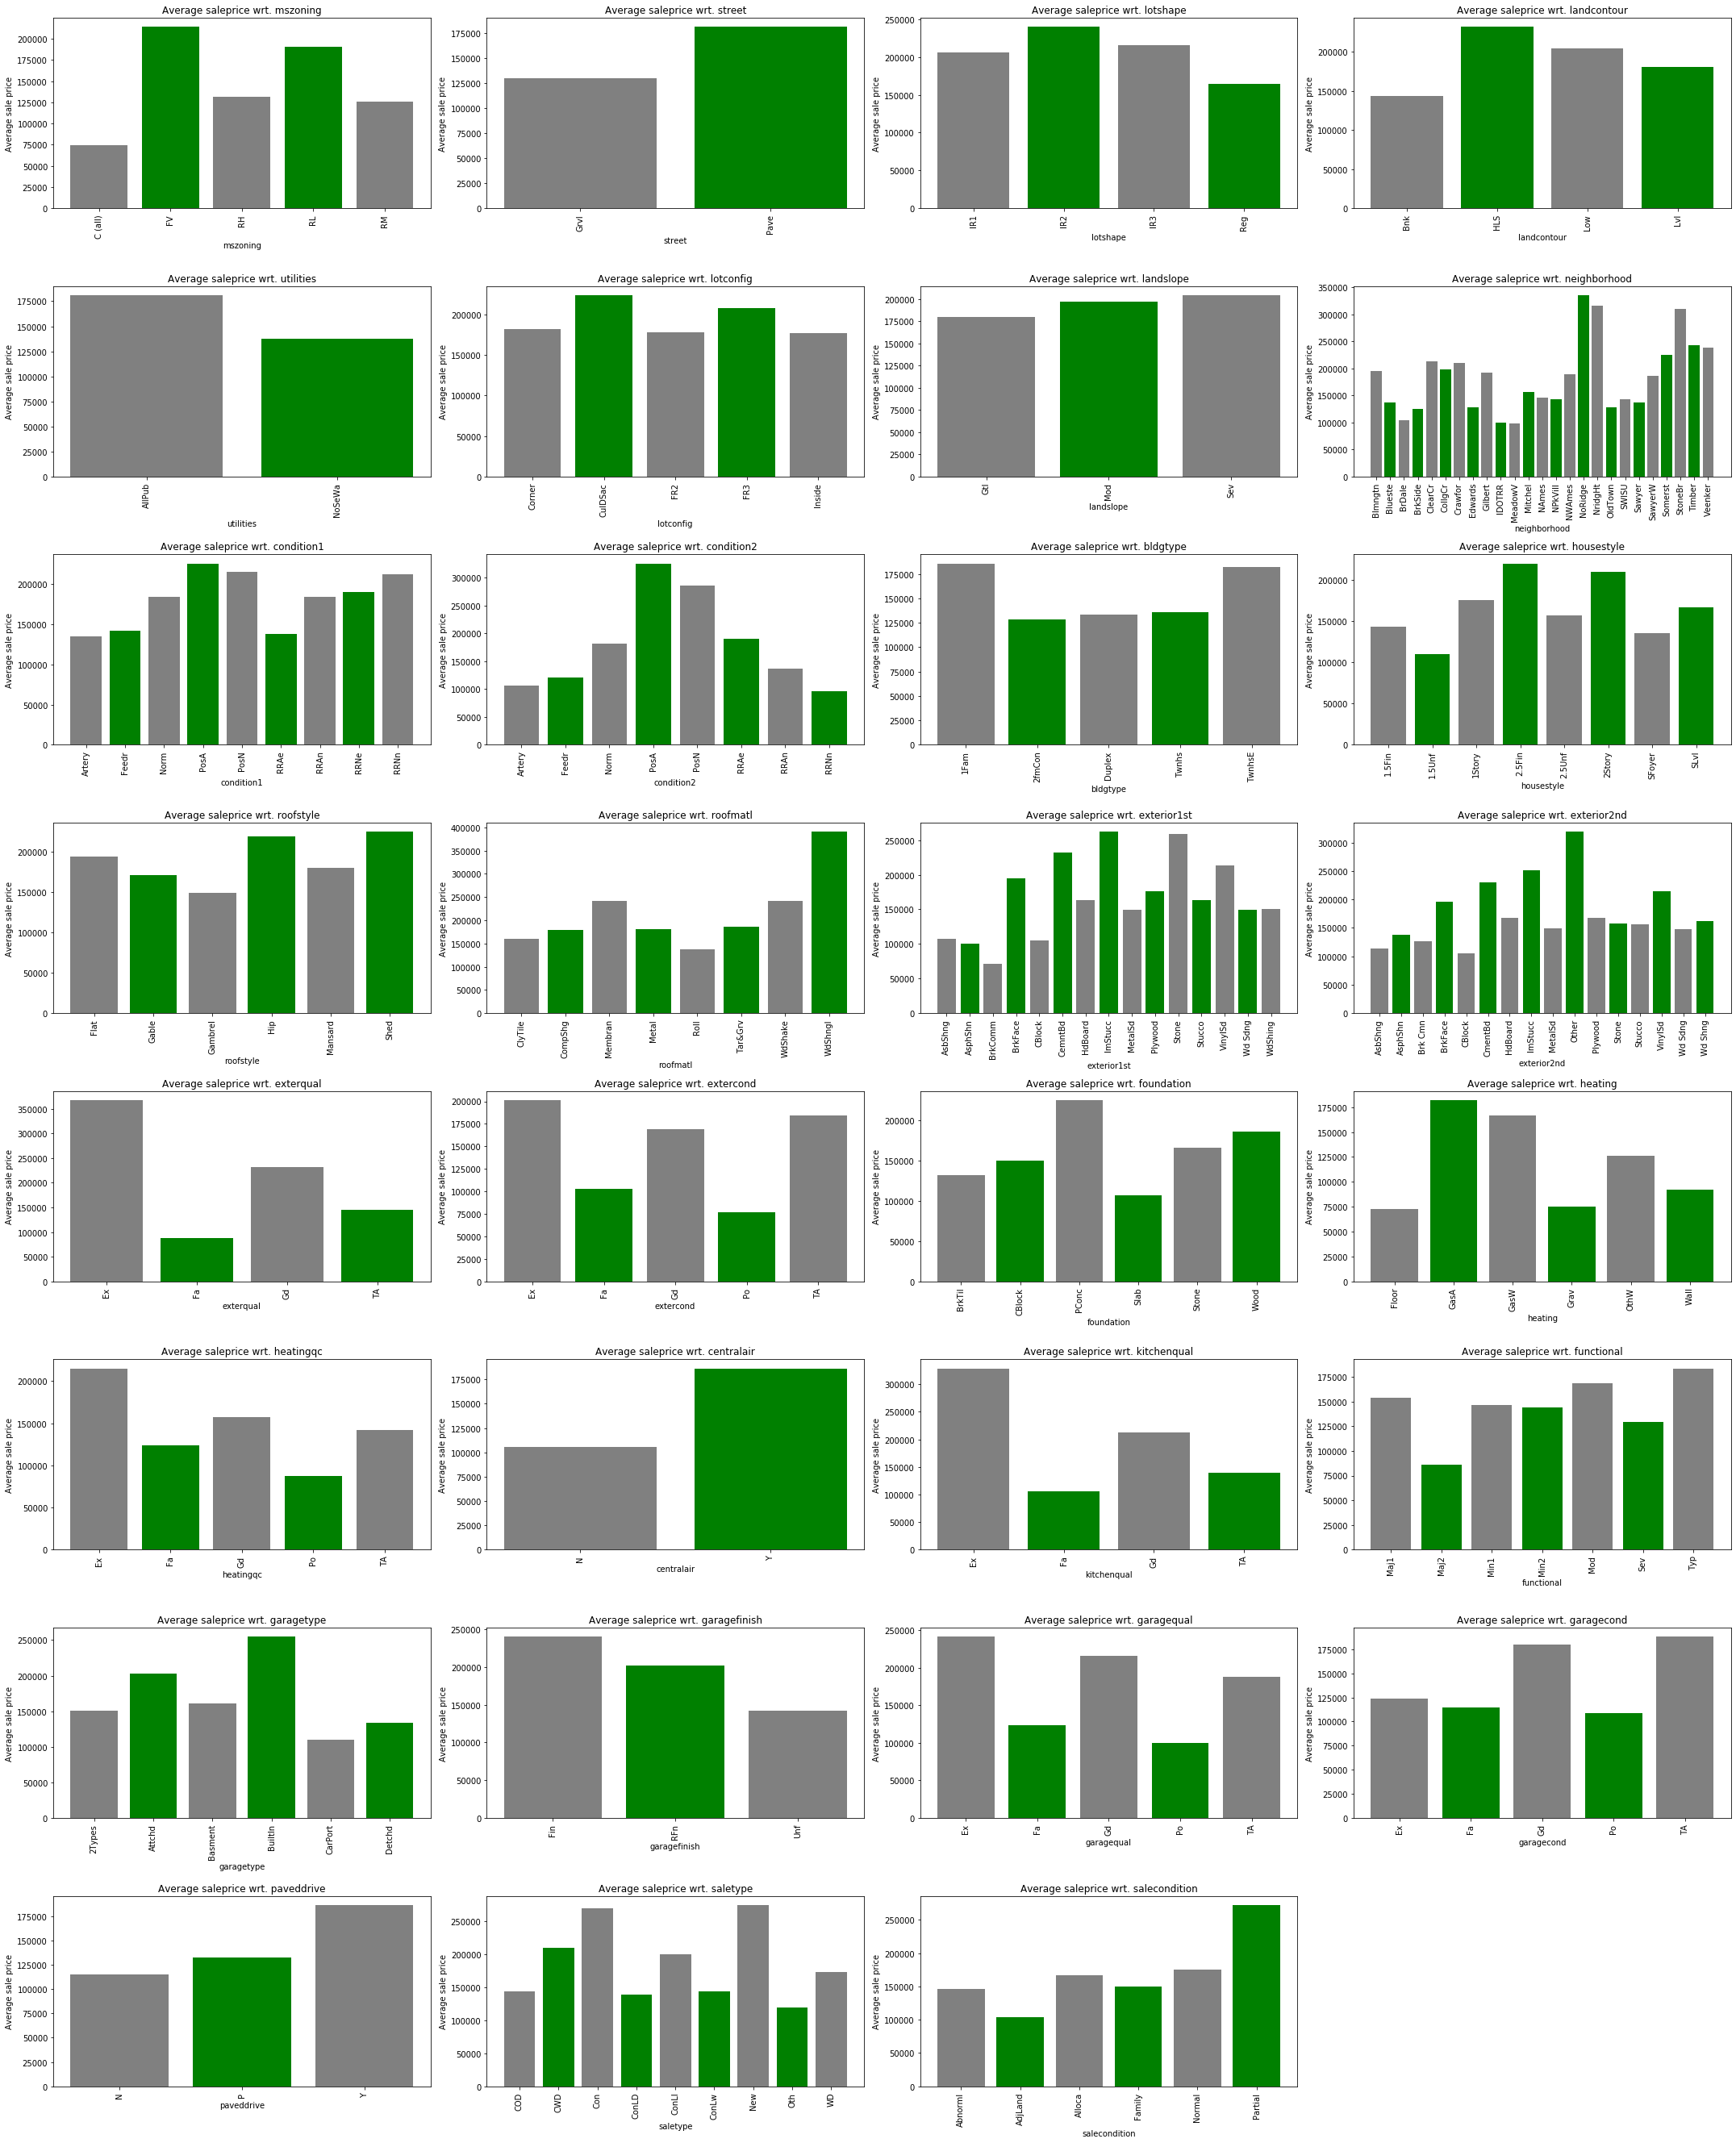

In [19]:
### Lets look at the non numeric columns to understand the data
### plotting non numeric columns - best to use bar plots
plt.figure(figsize = (30,50))
for index, column in enumerate(non_numeric_columns_df.columns):
    plt.subplot(11, 4, index+1)
    plt.bar(house_prices_df.groupby(column)["saleprice"].mean().index, house_prices_df.groupby(column)["saleprice"].mean(),
            color=("grey","green"))
    plt.title("Average saleprice wrt. {}".format(column))
    plt.ylabel("Average sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1d723fd0>,
      dtype=object)

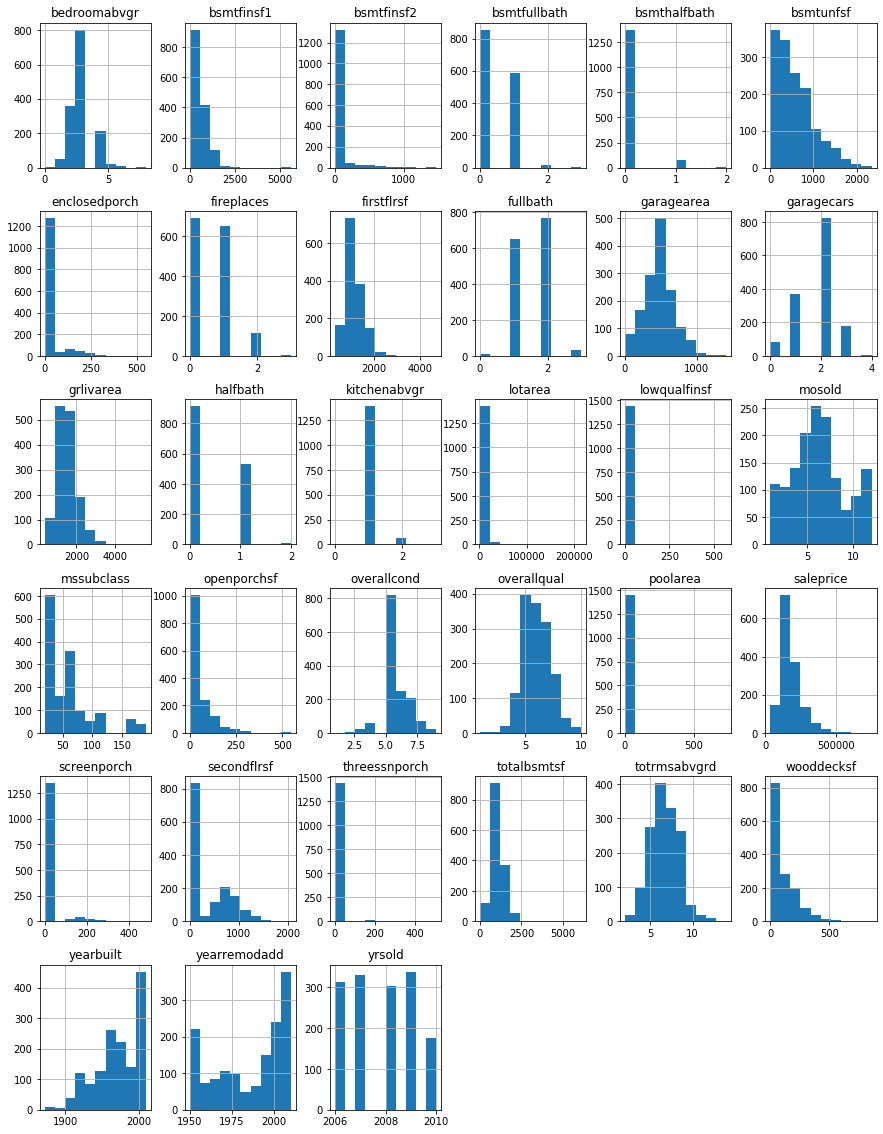

In [20]:
### Lets look at the numeric columns. A good way would be to plot histogram for numeric columns - 
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
numeric_col_df.hist(ax = ax)

In [21]:
numeric_col_df.describe()

,mssubclass,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,...,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,mosold,yrsold,saleprice
count,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,...,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000
mean,56.897,10516.828,6.099,5.575,1971.268,1984.866,443.640,46.549,567.240,1057.429,...,472.980,94.245,46.660,21.954,3.410,15.061,2.759,6.322,2007.816,180921.196
std,42.301,9981.265,1.383,1.113,30.203,20.645,456.098,161.319,441.867,438.705,...,213.805,125.339,66.256,61.119,29.317,55.757,40.177,2.704,1.328,79442.503
min,20.000,1300.000,1.000,1.000,1872.000,1950.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,2006.000,34900.000
25%,20.000,7553.500,5.000,5.000,1954.000,1967.000,0.000,0.000,223.000,795.750,...,334.500,0.000,0.000,0.000,0.000,0.000,0.000,5.000,2007.000,129975.000
50%,50.000,9478.500,6.000,5.000,1973.000,1994.000,383.500,0.000,477.500,991.500,...,480.000,0.000,25.000,0.000,0.000,0.000,0.000,6.000,2008.000,163000.000
75%,70.000,11601.500,7.000,6.000,2000.000,2004.000,712.250,0.000,808.000,1298.250,...,576.000,168.000,68.000,0.000,0.000,0.000,0.000,8.000,2009.000,214000.000
max,190.000,215245.000,10.000,9.000,2010.000,2010.000,5644.000,1474.000,2336.000,6110.000,...,1418.000,857.000,547.000,552.000,508.000,480.000,738.000,12.000,2010.000,755000.000


It seems like there are some outliers in the data - a lot of them are tailed outliers that we can see from the histogram.

### using boxcox
I have used box cox here and I spend 2 days and many many experiements and then found out that boxcox is completely messing my models.  Here is the box cox code and I stopped using it since it does not work on this data - I get 10% accuracy on the model and OLS tells me that my features are all -ve numbers

```
#numerical = numeric_columns = house_prices_df.select_dtypes(['int64','float64']).columns
for i in numeric_col_df.columns:
    if numeric_col_df[i].min() > 0:
        transformed, lamb = boxcox(numeric_col_df.loc[numeric_col_df[i].notnull(), i])
        if np.abs(1 - lamb) > 0.02:
            numeric_col_df.loc[numeric_col_df[i].notnull(), i] = transformed```
            
       

In [22]:
temp_df_num = numeric_col_df.copy()

In [23]:
for c in numeric_col_df.select_dtypes(['int64', 'float64']).columns:
    numeric_col_df[c] = np.log1p(numeric_col_df[c])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1c993310>,
      dtype=object)

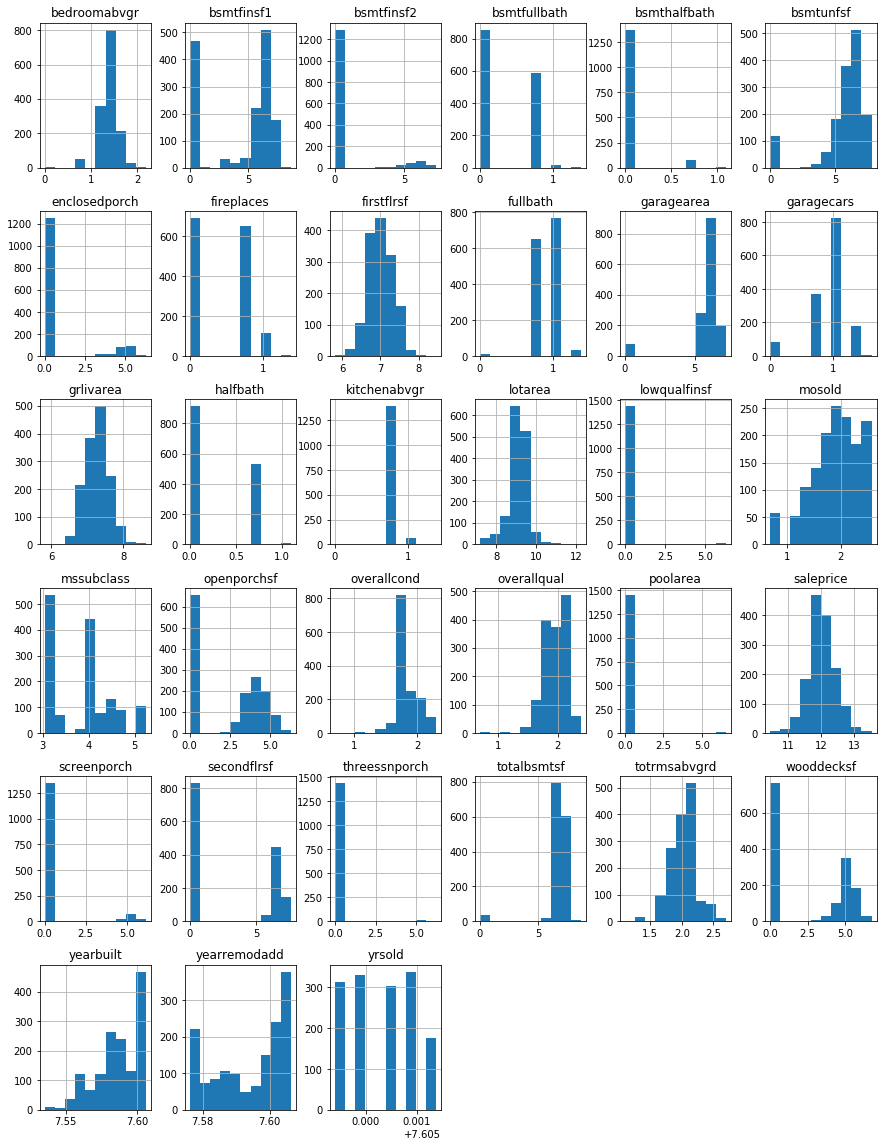

In [24]:
### histogram for numeric columns - best way to see correlation
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
numeric_col_df.hist(ax = ax)

In [25]:
### An interesting idea would be to think about combining features
### There are features which may not play much of a role individually but when 
### combines with others may have a bigger role
numeric_col_df['TotalSF'] = numeric_col_df['totalbsmtsf'] + numeric_col_df['firstflrsf'] + numeric_col_df['secondflrsf']

In [26]:
##dropping features that we combined
numeric_col_df.drop(['totalbsmtsf','firstflrsf','secondflrsf'], axis=1, inplace = True)

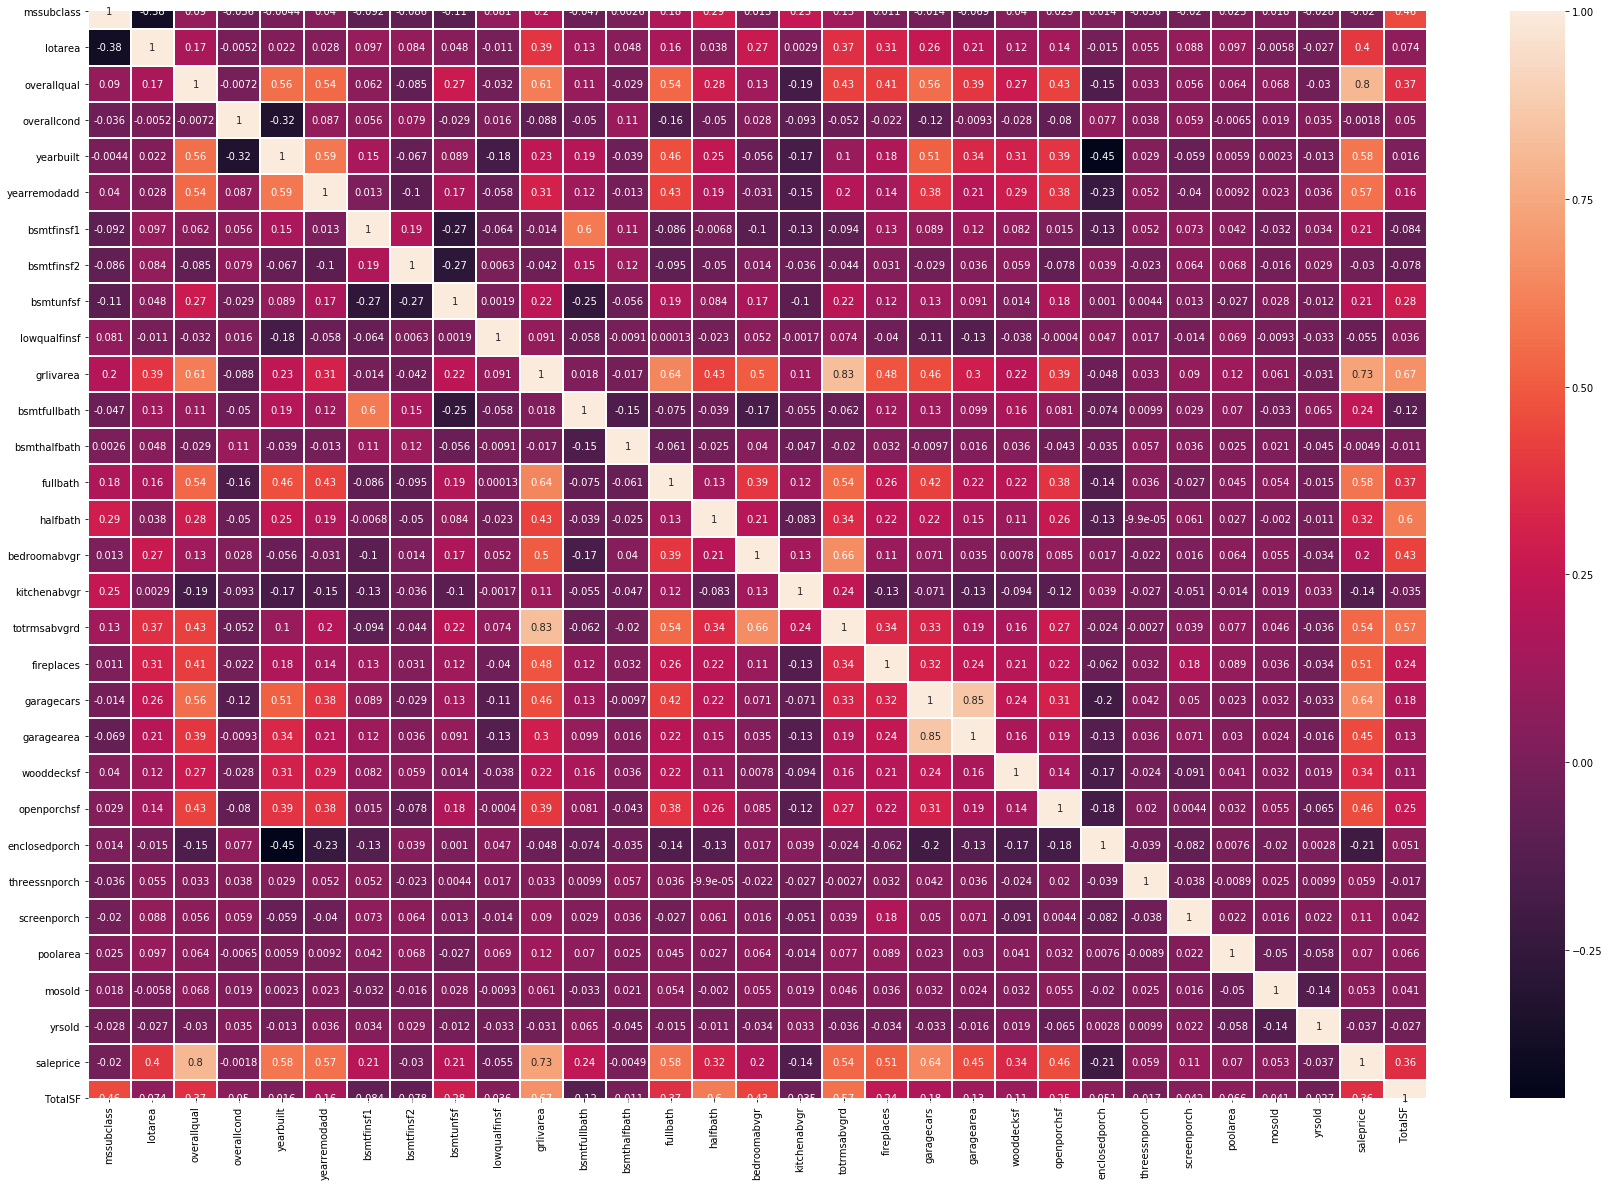

In [27]:
### look at correlation matrix and see what works best - look at the values and see what 
### has the least correlation.
plt.figure(figsize = (30,20))
sns.heatmap(numeric_col_df.corr(), linewidth=1, annot=True)
plt.show()

There are features that seem to have high correlation with each others. We will be removing those features.

In [28]:
numeric_col_df.drop(['garagearea'], axis=1, inplace = True)

In [29]:
### looking to see hig correlation with the target variable sale price
np.abs(numeric_col_df.corr().loc[:,"saleprice"]).sort_values(ascending=False)

saleprice       1.000
overallqual     0.802
grlivarea       0.730
garagecars      0.642
yearbuilt       0.584
fullbath        0.580
yearremodadd    0.566
totrmsabvgrd    0.540
fireplaces      0.509
openporchsf     0.460
lotarea         0.400
TotalSF         0.362
wooddecksf      0.343
halfbath        0.321
bsmtfullbath    0.239
bsmtunfsf       0.208
bsmtfinsf1      0.208
enclosedporch   0.207
bedroomabvgr    0.198
kitchenabvgr    0.144
screenporch     0.106
poolarea        0.070
threessnporch   0.059
lowqualfinsf    0.055
mosold          0.053
yrsold          0.037
bsmtfinsf2      0.030
mssubclass      0.020
bsmthalfbath    0.005
overallcond     0.002
Name: saleprice, dtype: float64

### Lets keep in mind that these features have high corr with saleprice
overallqual     0.802
grlivarea       0.730
garagecars      0.642
yearbuilt       0.584
fullbath        0.580
yearremodadd    0.566
totrmsabvgrd    0.540
fireplaces      0.509



overallqual     0.791
TotalSF         0.782
grlivarea       0.709
garagecars      0.640
fullbath        0.561
totrmsabvgrd    0.534
yearbuilt       0.523
yearremodadd    0.507

In [30]:
#numeric_col_df.describe()

In [31]:
### combine the 2 dataframes together - the numeric and the non numberic one
Final_housing_df = pd.concat([numeric_col_df,non_numeric_columns_df],axis=1)

In [32]:
#### Saving the final dataframe as a back up
temp_df = Final_housing_df.copy()

In [33]:
Final_housing_df.head(5)

,mssubclass,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,lowqualfinsf,...,centralair,kitchenqual,functional,garagetype,garagefinish,garagequal,garagecond,paveddrive,saletype,salecondition
0,4.111,9.042,2.079,1.792,7.603,7.603,6.561,0.000,5.017,0.000,...,Y,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1,3.045,9.170,1.946,2.197,7.589,7.589,6.887,0.000,5.652,0.000,...,Y,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,4.111,9.328,2.079,1.792,7.602,7.602,6.188,0.000,6.075,0.000,...,Y,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
3,4.263,9.164,2.079,1.792,7.558,7.586,5.380,0.000,6.293,0.000,...,Y,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,4.111,9.565,2.197,1.792,7.601,7.601,6.486,0.000,6.196,0.000,...,Y,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal


In [34]:
cols = Final_housing_df.select_dtypes(['object']).columns
print(cols)

Index(['mszoning', 'street', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'exterqual', 'extercond', 'foundation', 'heating',
       'heatingqc', 'centralair', 'kitchenqual', 'functional', 'garagetype',
       'garagefinish', 'garagequal', 'garagecond', 'paveddrive', 'saletype',
       'salecondition'],
      dtype='object')


In [35]:
#### taking care of categorical variables using label encoder
from sklearn.preprocessing import LabelEncoder

for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(Final_housing_df[c].values)) 
    Final_housing_df[c] = lbl.transform(list(Final_housing_df[c].values))

In [36]:
Final_housing_df.head(5)

,mssubclass,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,lowqualfinsf,...,centralair,kitchenqual,functional,garagetype,garagefinish,garagequal,garagecond,paveddrive,saletype,salecondition
0,4.111,9.042,2.079,1.792,7.603,7.603,6.561,0.000,5.017,0.000,...,1,2,6,1,2,5,5,2,8,4
1,3.045,9.170,1.946,2.197,7.589,7.589,6.887,0.000,5.652,0.000,...,1,3,6,1,2,5,5,2,8,4
2,4.111,9.328,2.079,1.792,7.602,7.602,6.188,0.000,6.075,0.000,...,1,2,6,1,2,5,5,2,8,4
3,4.263,9.164,2.079,1.792,7.558,7.586,5.380,0.000,6.293,0.000,...,1,2,6,5,3,5,5,2,8,0
4,4.111,9.565,2.197,1.792,7.601,7.601,6.486,0.000,6.196,0.000,...,1,2,6,1,2,5,5,2,8,4


In [37]:
np.abs(Final_housing_df.corr().loc[:,"saleprice"]).sort_values(ascending=False)

saleprice      1.000
overallqual    0.802
grlivarea      0.730
garagecars     0.642
yearbuilt      0.584
                ... 
mssubclass     0.020
utilities      0.013
bsmthalfbath   0.005
overallcond    0.002
condition2     0.001
Name: saleprice, Length: 61, dtype: float64

### These are the features that have > 50% corr with saleprice
- overallqual     0.791
- TotalSF         0.782
- grlivarea       0.709
- garagecars      0.640
- exterqual       0.637
- kitchenqual     0.589
- fullbath        0.561
- totrmsabvgrd    0.534
- yearbuilt       0.523
- yearremodadd    0.507

### Getting target variables and features

In [38]:
#Y=Final_housing_df['saleprice']
Y=Final_housing_df['saleprice'].values

In [39]:
Final_housing_df.drop(['saleprice'], axis = 1, inplace=True)

In [40]:
X = Final_housing_df.values

### Train / test split cross validation

In [41]:
### cross validation using train/test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 7)

alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

### Modeling with Linear regression, OLS, Lasso, Ridge and Elaticnet

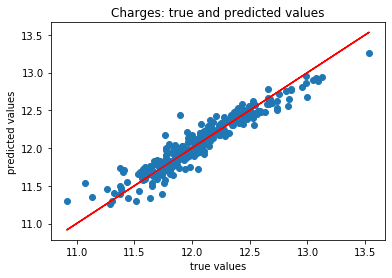

R-squared of the model in training set is: 0.8898584208247345
-----Test set statistics-----
R-squared of the model in test set is: 0.9046904307062542
Mean absolute error of the prediction is: 0.09276202700546458
Mean squared error of the prediction is: 0.015322586215165598
Root mean squared error of the prediction is: 0.12378443446235718
Mean absolute percentage error of the prediction is: 0.771849955130431


In [42]:
### Linear regression
lrm = LinearRegression()

lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

In [43]:
### K mean cross validation
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(lrm, X_train,y_train, cv=5)
print(cv_scores)
print('cv_scores mean: {}'.format(np.mean(cv_scores)))

[0.8787471  0.68997072 0.86604276 0.881956   0.89408746]
cv_scores mean: 0.8421608085769151


The train dataset gives us 88.9%. K-mean cross validation gives us 84%. The discrepency seems to be on the second cross validation which is 68% - the other ones are close to each other so the 2nd one is throwing the results off a little bit. This could be due to some features or data that may not be correct.

In [44]:
### OLS model
import statsmodels.api as sm
# We need to manually add a constant
# in statsmodels' sm
X_train = sm.add_constant(X_train)

results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     149.1
Date:                Tue, 03 Mar 2020   Prob (F-statistic):               0.00
Time:                        22:44:41   Log-Likelihood:                 705.15
No. Observations:                1168   AIC:                            -1288.
Df Residuals:                    1107   BIC:                            -979.5
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         88.7665     48.289      1.838      0.066      -5.982     183.515
x1            -0.0172      0.015     -1.138      0.256      -0.047       0.012
x2             0.0907      0.012      7.417      0.000       0.067       0.115
x3             0.4202      0.036     11.658      0.000       0.349       0.491
x4             0.2504      0.030      8.219      0.000       0.191       0.310
x5             3.8318      0.678      5.648      0.000       2.501       5.163
x6             1.1866      0.614      1.932      0.054      -0.018       2.391
x7             0.0119      0.002      6.320      0.000       0.008       0.016
x8             0.0015      0.002      0.610      0.542      -0.003       0.006
x9             0.0065      0.003      2.377      0.018       0.001       0.012
x10           -0.0105      0.006     -1.818      0.069      -0.022       0.001
x11            0.4645      0.035     13.304      0.000       0.396       0.533
x12            0.0657      0.016      4.123      0.000       0.034       0.097
x13            0.0238      0.027      0.898      0.370      -0.028       0.076
x14            0.0765      0.031      2.482      0.013       0.016       0.137
x15            0.0107      0.018      0.605      0.545      -0.024       0.046
x16           -0.0621      0.028     -2.220      0.027      -0.117      -0.007
x17           -0.1911      0.060     -3.212      0.001      -0.308      -0.074
x18            0.0689      0.041      1.661      0.097      -0.012       0.150
x19            0.0366      0.013      2.784      0.005       0.011       0.062
x20            0.1221      0.019      6.505      0.000       0.085       0.159
x21            0.0037      0.002      2.131      0.033       0.000       0.007
x22           -0.0010      0.002     -0.448      0.654      -0.005       0.003
x23            0.0033      0.003      1.219      0.223      -0.002       0.009
x24           -0.0002      0.006     -0.042      0.967      -0.012       0.011
x25            0.0112      0.003      3.692      0.000       0.005       0.017
x26           -0.0277      0.010     -2.711      0.007      -0.048      -0.008
x27            0.0019      0.010      0.189      0.851      -0.018       0.021
x28          -15.8534      6.315     -2.511      0.012     -28.243      -3.464
x29           -0.0069      0.003     -2.569      0.010      -0.012      -0.002
x30            0.0006      0.007      0.087      0.931      -0.014       0.015
x31            0.1672      0.065      2.574      0.010       0.040       0.295
x32           -0.0042      0.003     -1.309      0.191      -0.010       0.002
x33            0.0119      0.006      1.852      0.064      -0.001       0.024
x34           -0.2169      0.143     -1.520      0.129      -0.497       0.063
x35           -0.0015      0.003     -0.577      0.564      -0.007       0.004
x3

Some of the features in that summary report shows that the p value not < 0.05 making those features not very significant. That could be the reason for the CV scores to be a little off.

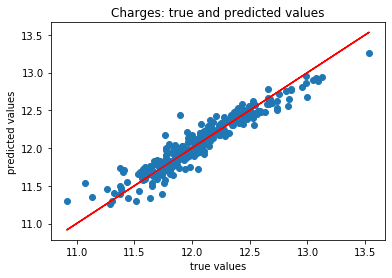

Mean absolute error of the prediction is: 0.09276202700547893
Mean squared error of the prediction is: 0.015322586215170396
Root mean squared error of the prediction is: 0.12378443446237655
Mean absolute percentage error of the prediction is: 0.7718499551305753


In [45]:
# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

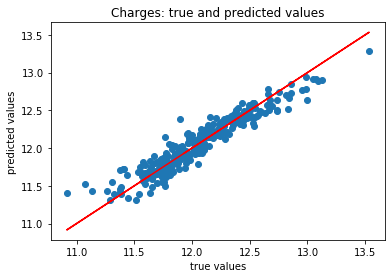

Best alpha value is: 0.001
R-squared of the model in training set is: 0.8806392996183643
-----Test set statistics-----
R-squared of the model in test set is: 0.8973056302957086
Mean absolute error of the prediction is: 0.09788210337836006
Mean squared error of the prediction is: 0.01650981475696742
Root mean squared error of the prediction is: 0.12849052399678126
Mean absolute percentage error of the prediction is: 0.8147685193306003


In [46]:
### Lasso 
lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Lasso is very close to the linear regression results

linear regression: 

R-squared of the model in training set is: 0.8898584208247345
-----Test set statistics-----
R-squared of the model in test set is: 0.9046904307062542
Mean absolute error of the prediction is: 0.09276202700546458
Mean squared error of the prediction is: 0.015322586215165598
Root mean squared error of the prediction is: 0.12378443446235718
Mean absolute percentage error of the prediction is: 0.771849955130431

Lasso: 
Best alpha value is: 0.001
R-squared of the model in training set is: 0.8806392996183643
-----Test set statistics-----
R-squared of the model in test set is: 0.8973056302957086
Mean absolute error of the prediction is: 0.09788210337836006
Mean squared error of the prediction is: 0.01650981475696742
Root mean squared error of the prediction is: 0.12849052399678126
Mean absolute percentage error of the prediction is: 0.814768519330600

Between the 2, Linear regression is better - RMSE is lower than Lasso and prediction for test is higher

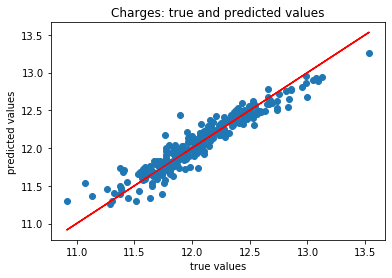

Best alpha value is: 0.0001
R-squared of the model in training set is: 0.8898386534102425
-----Test set statistics-----
R-squared of the model in test set is: 0.9046946871121193
Mean absolute error of the prediction is: 0.09280217893415951
Mean squared error of the prediction is: 0.01532190192767674
Root mean squared error of the prediction is: 0.1237816704026761
Mean absolute percentage error of the prediction is: 0.77218386152255


In [47]:
ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

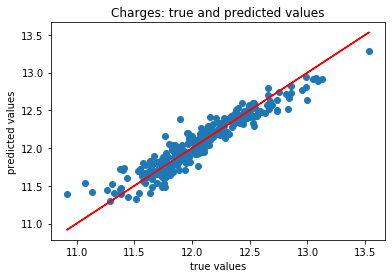

Best alpha value is: 0.001
R-squared of the model in training set is: 0.8827153144439441
-----Test set statistics-----
R-squared of the model in test set is: 0.8972544837060292
Mean absolute error of the prediction is: 0.09791567997586531
Mean squared error of the prediction is: 0.016518037415361356
Root mean squared error of the prediction is: 0.12852251715307073
Mean absolute percentage error of the prediction is: 0.8151872204131121


In [48]:
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Lasso is very close to the linear regression results

linear regression: 
----------------------

R-squared of the model in training set is: 0.8898584208247345
-----Test set statistics-----
R-squared of the model in test set is: 0.9046904307062542
Mean absolute error of the prediction is: 0.09276202700546458
Mean squared error of the prediction is: 0.015322586215165598
Root mean squared error of the prediction is: 0.12378443446235718
Mean absolute percentage error of the prediction is: 0.771849955130431

Lasso: 
------------
Best alpha value is: 0.001
R-squared of the model in training set is: 0.8806392996183643
-----Test set statistics-----
R-squared of the model in test set is: 0.8973056302957086
Mean absolute error of the prediction is: 0.09788210337836006
Mean squared error of the prediction is: 0.01650981475696742
Root mean squared error of the prediction is: 0.12849052399678126
Mean absolute percentage error of the prediction is: 0.814768519330600

Ridge
-------
Best alpha value is: 0.0001
R-squared of the model in training set is: 0.8898386534102425
-----Test set statistics-----
R-squared of the model in test set is: 0.9046946871121193
Mean absolute error of the prediction is: 0.09280217893415951
Mean squared error of the prediction is: 0.01532190192767674
Root mean squared error of the prediction is: 0.1237816704026761
Mean absolute percentage error of the prediction is: 0.77218386152255


Elasticnet
-----------

Best alpha value is: 0.001
R-squared of the model in training set is: 0.8827153144439441
-----Test set statistics-----
R-squared of the model in test set is: 0.8972544837060292
Mean absolute error of the prediction is: 0.09791567997586531
Mean squared error of the prediction is: 0.016518037415361356
Root mean squared error of the prediction is: 0.12852251715307073
Mean absolute percentage error of the prediction is: 0.8151872204131121


Between the 4, Linear regression and Ridge has pretty much the same output - RMSE is lower than Lasso and elasticnet and prediction for test is higher - so I would say Linear and RidgeCV would be choice of model here

The other thing to note is that from the OLS summary - a lot of the features had p value > 0.05 that means that those features are not significant 

I want to look and see if we can extract some of the features that had high correlation with saleprice and see if that will make any difference and we can get better accuracy score and test result 

In [49]:
### looking at the OLS and features and taking features that are significant
Final_housing_df_2 = Final_housing_df[['overallqual', 'TotalSF', 'grlivarea','garagecars',
                                        'totrmsabvgrd','yearbuilt','yearremodadd','fireplaces']]

In [50]:
Final_housing_df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 8 columns):
overallqual     1460 non-null float64
TotalSF         1460 non-null float64
grlivarea       1460 non-null float64
garagecars      1460 non-null float64
totrmsabvgrd    1460 non-null float64
yearbuilt       1460 non-null float64
yearremodadd    1460 non-null float64
fireplaces      1460 non-null float64
dtypes: float64(8)
memory usage: 91.4 KB


In [51]:
X = Final_housing_df_2.values
#Y = Y.values

In [52]:
### cross validation using train/test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 7)

alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

In [53]:
import statsmodels.api as sm
# We need to manually add a constant
# in statsmodels' sm
X_train = sm.add_constant(X_train)

results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     652.0
Date:                Tue, 03 Mar 2020   Prob (F-statistic):               0.00
Time:                        22:44:57   Log-Likelihood:                 412.47
No. Observations:                1168   AIC:                            -806.9
Df Residuals:                    1159   BIC:                            -761.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -58.4381      4.670    -12.513      0.000     -67.601     -49.275
x1             0.6091      0.039     15.579      0.000       0.532       0.686
x2            -0.0108      0.002     -5.333      0.000      -0.015      -0.007
x3             0.5115      0.035     14.459      0.000       0.442       0.581
x4             0.1731      0.020      8.633      0.000       0.134       0.212
x5            -0.0239      0.042     -0.568      0.570      -0.107       0.059
x6             3.8993      0.456      8.555      0.000       3.005       4.794
x7             4.7404      0.628      7.543      0.000       3.507       5.973
x8             0.1034      0.015      6.885      0.000       0.074       0.133
==============================================================================
Omnibus:                      228.985   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1062.881
Skew:                          -0.840   Prob(JB):                    1.58e-231
Kurtosis:                       7.361   Cond. No.                     2.02e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.02e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

There is still one feature that has a pvalue > 0.05

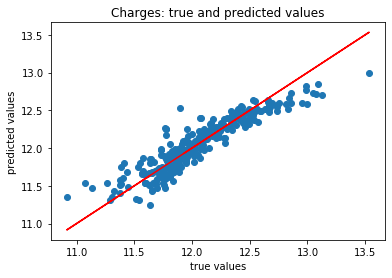

Mean absolute error of the prediction is: 0.12165322825752876
Mean squared error of the prediction is: 0.025943597858309807
Root mean squared error of the prediction is: 0.16107016439524052
Mean absolute percentage error of the prediction is: 1.0112539434497472


In [54]:
# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

The plot looks worst than the model before - in the previous models with the previous features the line was fitten somewhat properly and closer to the regression line. In this one, they are off. This will result in the accuracy being lower than before probably.

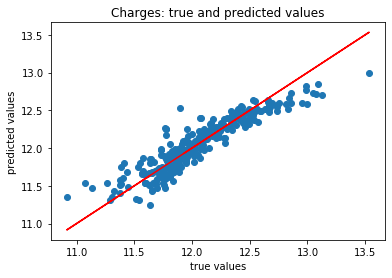

R-squared of the model in training set is: 0.8181957153673433
-----Test set statistics-----
R-squared of the model in test set is: 0.8386256012474989
Mean absolute error of the prediction is: 0.12165322825753047
Mean squared error of the prediction is: 0.0259435978583104
Root mean squared error of the prediction is: 0.16107016439524235
Mean absolute percentage error of the prediction is: 1.0112539434497605


In [55]:
lrm = LinearRegression()

lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

In [56]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(lrm, X_train,y_train, cv=5)
print(cv_scores)
print('cv_scores mean: {}'.format(np.mean(cv_scores)))

[0.82764984 0.72621693 0.78903898 0.8408245  0.86667759]
cv_scores mean: 0.8100815701820416


The accuracy scores are lower than before and this time there are more cross validations that are showing off than before. Therefore the featurset previously was better. This also gives higher MSE and RMSE than before. Therefore the previous features and models were better

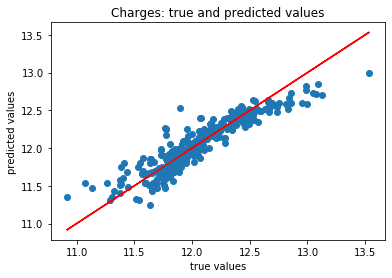

Best alpha value is: 1e-06
R-squared of the model in training set is: 0.818195624601115
-----Test set statistics-----
R-squared of the model in test set is: 0.8386157030843109
Mean absolute error of the prediction is: 0.12166348858157383
Mean squared error of the prediction is: 0.025945189151398207
Root mean squared error of the prediction is: 0.1610751040707353
Mean absolute percentage error of the prediction is: 1.0113442834906097


In [57]:
lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)


plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

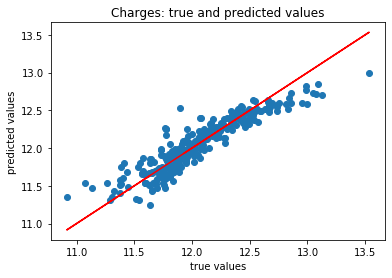

Best alpha value is: 0.0001
R-squared of the model in training set is: 0.8181957007361189
-----Test set statistics-----
R-squared of the model in test set is: 0.8386221749715003
Mean absolute error of the prediction is: 0.12165732264696251
Mean squared error of the prediction is: 0.02594414868872308
Root mean squared error of the prediction is: 0.1610718742944375
Mean absolute percentage error of the prediction is: 1.0112898941691493


In [58]:
ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

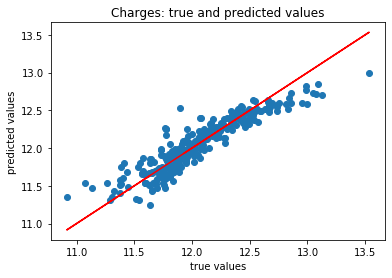

Best alpha value is: 1e-07
R-squared of the model in training set is: 0.8181957080433323
-----Test set statistics-----
R-squared of the model in test set is: 0.8386231104354759
Mean absolute error of the prediction is: 0.12165613301899202
Mean squared error of the prediction is: 0.025943998297450463
Root mean squared error of the prediction is: 0.1610714074485303
Mean absolute percentage error of the prediction is: 1.0112794609621232


In [59]:
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

After running all the model, the previous features would be better to use.

## External factors

So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.

The external factors that I am interested to know would be the housing market crash.
- I want to look at what are years the houses were sold
- I would be interested in knowing the relationship between the sold year and the sale price of those houses

In [60]:
### years houses were sold
house_prices_df['yrsold'].value_counts()

2009    338
2007    329
2006    314
2008    304
2010    175
Name: yrsold, dtype: int64

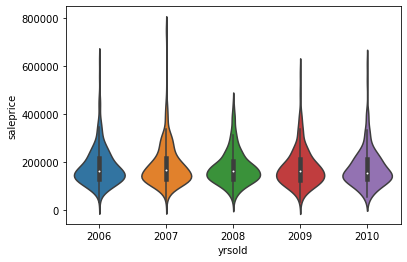

In [61]:
### Relationship between yrsold and sale price
sns.violinplot(x="yrsold", y="saleprice", data=house_prices_df)

I will be adding interest rates for the years the houses were sold to see how interest rates affect the housing prices at all or not. I found the historical interest rates from here: https://www.valuepenguin.com/mortgages/historical-mortgage-rates#hist and I will take the average interest rate


In [62]:
dict_interest_rate = {2006:6.41, 2007:6.34, 2008:6.03, 2009:5.04, 2010:4.69}

In [63]:
### Adding that to the dataframe
house_prices_df['interest_rate'] = house_prices_df['yrsold'].map(dict_interest_rate) 

In [64]:
house_prices_df.head(5)

,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,...,poolarea,poolqc,fence,miscfeature,mosold,yrsold,saletype,salecondition,saleprice,interest_rate
0,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,2,2008,WD,Normal,208500,6.030
1,20,RL,80.000,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,None,None,None,5,2007,WD,Normal,181500,6.340
2,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,None,None,None,9,2008,WD,Normal,223500,6.030
3,70,RL,60.000,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,None,None,None,2,2006,WD,Abnorml,140000,6.410
4,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,None,None,None,12,2008,WD,Normal,250000,6.030


In [65]:
housing_with_interest = Final_housing_df.copy()

In [66]:
housing_with_interest['interest_rate'] = house_prices_df['interest_rate']

In [67]:
housing_with_interest.head(5)

,mssubclass,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,lowqualfinsf,...,kitchenqual,functional,garagetype,garagefinish,garagequal,garagecond,paveddrive,saletype,salecondition,interest_rate
0,4.111,9.042,2.079,1.792,7.603,7.603,6.561,0.000,5.017,0.000,...,2,6,1,2,5,5,2,8,4,6.030
1,3.045,9.170,1.946,2.197,7.589,7.589,6.887,0.000,5.652,0.000,...,3,6,1,2,5,5,2,8,4,6.340
2,4.111,9.328,2.079,1.792,7.602,7.602,6.188,0.000,6.075,0.000,...,2,6,1,2,5,5,2,8,4,6.030
3,4.263,9.164,2.079,1.792,7.558,7.586,5.380,0.000,6.293,0.000,...,2,6,5,3,5,5,2,8,0,6.410
4,4.111,9.565,2.197,1.792,7.601,7.601,6.486,0.000,6.196,0.000,...,2,6,1,2,5,5,2,8,4,6.030


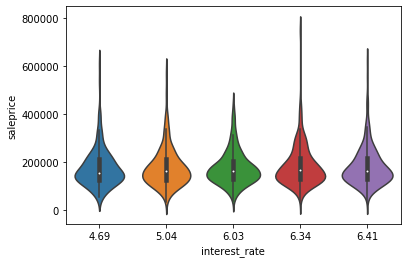

In [68]:
sns.violinplot(x="interest_rate", y="saleprice", data=house_prices_df)

The sale prices seems to be pretty flat and it does not seem like the interest rate will have much effect in the sale price. But lets use the model and see if that's true

### Modeling with external factor

In [69]:
X = housing_with_interest.values

In [70]:
### cross validation using train/test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 7)

alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

In [71]:
### OLS
import statsmodels.api as sm
# We need to manually add a constant
# in statsmodels' sm
X_train = sm.add_constant(X_train)

results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     146.5
Date:                Tue, 03 Mar 2020   Prob (F-statistic):               0.00
Time:                        22:45:28   Log-Likelihood:                 705.16
No. Observations:                1168   AIC:                            -1286.
Df Residuals:                    1106   BIC:                            -972.4
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         80.4547    140.984      0.571      0.568    -196.171     357.081
x1            -0.0172      0.015     -1.138      0.255      -0.047       0.012
x2             0.0907      0.012      7.404      0.000       0.067       0.115
x3             0.4201      0.036     11.637      0.000       0.349       0.491
x4             0.2503      0.031      8.190      0.000       0.190       0.310
x5             3.8324      0.679      5.645      0.000       2.500       5.164
x6             1.1850      0.615      1.927      0.054      -0.021       2.391
x7             0.0119      0.002      6.304      0.000       0.008       0.016
x8             0.0015      0.002      0.607      0.544      -0.003       0.006
x9             0.0065      0.003      2.365      0.018       0.001       0.012
x10           -0.0104      0.006     -1.814      0.070      -0.022       0.001
x11            0.4645      0.035     13.297      0.000       0.396       0.533
x12            0.0657      0.016      4.122      0.000       0.034       0.097
x13            0.0238      0.027      0.896      0.370      -0.028       0.076
x14            0.0765      0.031      2.481      0.013       0.016       0.137
x15            0.0107      0.018      0.603      0.547      -0.024       0.046
x16           -0.0622      0.028     -2.220      0.027      -0.117      -0.007
x17           -0.1912      0.060     -3.211      0.001      -0.308      -0.074
x18            0.0689      0.041      1.661      0.097      -0.012       0.150
x19            0.0366      0.013      2.784      0.005       0.011       0.062
x20            0.1221      0.019      6.502      0.000       0.085       0.159
x21            0.0037      0.002      2.130      0.033       0.000       0.007
x22           -0.0010      0.002     -0.447      0.655      -0.005       0.003
x23            0.0033      0.003      1.217      0.224      -0.002       0.009
x24           -0.0003      0.006     -0.043      0.966      -0.012       0.011
x25            0.0112      0.003      3.687      0.000       0.005       0.017
x26           -0.0277      0.010     -2.710      0.007      -0.048      -0.008
x27            0.0019      0.010      0.189      0.850      -0.018       0.021
x28          -14.7603     18.529     -0.797      0.426     -51.116      21.595
x29           -0.0069      0.003     -2.565      0.010      -0.012      -0.002
x30            0.0006      0.007      0.086      0.932      -0.014       0.015
x31            0.1673      0.065      2.574      0.010       0.040       0.295
x32           -0.0042      0.003     -1.309      0.191      -0.010       0.002
x33            0.0119      0.006      1.852      0.064      -0.001       0.024
x34           -0.2166      0.143     -1.516      0.130      -0.497       0.064
x35           -0.0015      0.003     -0.580      0.562      -0.007       0.004
x3

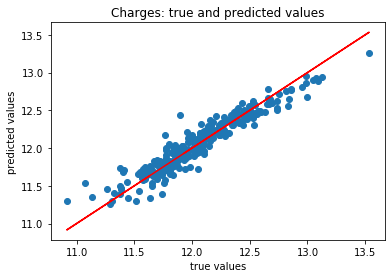

Mean absolute error of the prediction is: 0.09274250189803551
Mean squared error of the prediction is: 0.015320872478749034
Root mean squared error of the prediction is: 0.1237775120074282
Mean absolute percentage error of the prediction is: 0.7716834554355628


In [72]:
# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

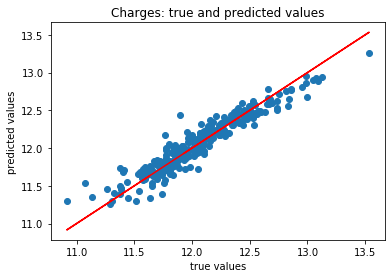

R-squared of the model in training set is: 0.8898588130166661
-----Test set statistics-----
R-squared of the model in test set is: 0.9047010904912753
Mean absolute error of the prediction is: 0.09274250189817157
Mean squared error of the prediction is: 0.015320872478798597
Root mean squared error of the prediction is: 0.12377751200762842
Mean absolute percentage error of the prediction is: 0.7716834554369403


In [73]:
### Linear regression
lrm = LinearRegression()

lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

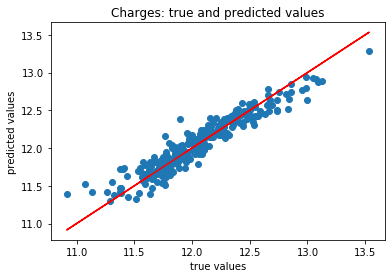

Best alpha value is: 0.001
R-squared of the model in training set is: 0.8813433512097042
-----Test set statistics-----
R-squared of the model in test set is: 0.8981847086263508
Mean absolute error of the prediction is: 0.09711115188410607
Mean squared error of the prediction is: 0.016368488407357808
Root mean squared error of the prediction is: 0.12793939349300437
Mean absolute percentage error of the prediction is: 0.8083511468465613


In [74]:
lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)


plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

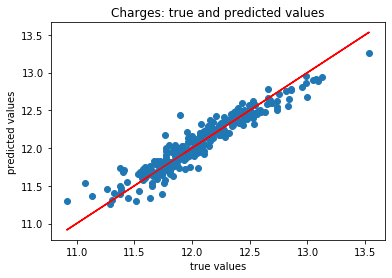

Best alpha value is: 0.001
R-squared of the model in training set is: 0.8898001373876904
-----Test set statistics-----
R-squared of the model in test set is: 0.9047645055869508
Mean absolute error of the prediction is: 0.09261347357152215
Mean squared error of the prediction is: 0.01531067745559128
Root mean squared error of the prediction is: 0.12373632229701706
Mean absolute percentage error of the prediction is: 0.7705809624587494


In [75]:
ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

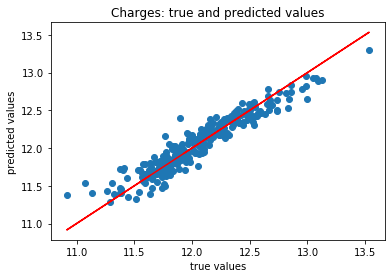

Best alpha value is: 0.001
R-squared of the model in training set is: 0.8833463741047622
-----Test set statistics-----
R-squared of the model in test set is: 0.8980539197745767
Mean absolute error of the prediction is: 0.09704735341078254
Mean squared error of the prediction is: 0.016389514873767656
Root mean squared error of the prediction is: 0.12802154066315424
Mean absolute percentage error of the prediction is: 0.8079397568404263


In [76]:
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

As suspected, adding the interest rate does not seem to have much effect in the sale price.

### Summary


The purpose of this assignment was to use different models to see whoch one of them would be good at predicting housing prices. The target variable is the saleprice.

I took the housing data and use several techniques to clean the data. I used exploratory analysis to look at the data closely. 

I seperated the numeric and non numeric columns so I would have a better idea of the different features. 

There were missing data and I handled it by removing the columns missing values. We have a lot of columns, as well as the columns did not seem like they would add much value to the  preduction. Therefore I removed the columns.

I used box plot, bar plot and histograms to see the distributions of the different features. There were outliers including the target variable. I tried to use BoxCox and I spend a lot of time but it seems like box cox somehow completely corrupts my data. There must be something about boxcox or the way I am using it, it was not working at all.
Here is the code for that.
``` Here is the box cox code and I stopped using it since it does not work on this data - I get 10% accuracy on the model and OLS tells me that my features are all -ve numbers

#numerical = numeric_columns = house_prices_df.select_dtypes(['int64','float64']).columns
for i in numeric_col_df.columns:
    if numeric_col_df[i].min() > 0:
        transformed, lamb = boxcox(numeric_col_df.loc[numeric_col_df[i].notnull(), i])
        if np.abs(1 - lamb) > 0.02:
            numeric_col_df.loc[numeric_col_df[i].notnull(), i] = transformed
```
      
When boxcox failed, I went to log transformation. Since the histograms showed tailed distributions, log transformation would have worked well and it did.

Once missing values were taken care of, outliers were taken care of, I started looking into the correlation of the different features. I started with the numberic features to see how the correlation is. I had to eliminate a few features since they had high correlatio with each others. 

After that I took the categorical data and identified the features that would be best suited to predict the sale price. Once I have identified them, I use the encoder to get the numberic values of the different categories.

Once that was done, I looked at correlation of the non numberic columns to sale price. In this process, I again eliminated some the of features that had high correlation to each other.

At this point, the data was clean and features were identified to be good ones that may have the ability to predict the sale price. Then I combined the numberic and non numberic data. 

At this point, I am ready for the data to be used in the model. I split them to train and test data sets. I chose the following regression models

- linear regression
- OLS
- Lasso
- Ridge
- ElasticNet

With all the identified features (~61 of them) I use the models. The model to predict the sale price is the linear regressin model. ~89% accuracy with test data having 90% accuracy. The next model that came close to that is Ridge - 

I wanted to see if the model could be tuned and made better - so I only selected 10 features. Ofcourse, I carefully chose the features so they may contribute to predicting the same price. In this case, the model accuracy score went down. Also if we look at the graph, it does not fit properly.

The last item that was askd from us is to use some common api or make up the data for external facot. I chose interest rates to be the external. After much data analysis, I chose interest rates to be the external factor. 

With the interest rate, predicting the sale price using the models brought the accuracy with of that dataset lower. So although I feel like interest rate would have made a difference in predicting housing prices, in reality that's not the case - the accuracy score 
